In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner

/home2/shubh/.conda/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# vit_model_name = "20230728_resnet_DES_half_sky"
# resnet_model_name = "20230728_resnet_DES"

# vit_model_name = "20230725_vit_DES_half_sky"
# resnet_model_name = "20230725_vit_DES"

vit_model_name = "20230711_vit_noisy_6_params_no_norm"
resnet_model_name = "20230715_resnet_noisy_6_params_no_norm"

vit_preds = np.load(f"../models/{vit_model_name}/preds0.npy")
resnet_preds = np.load(f"../models/{resnet_model_name}/preds0.npy")
vit_labels = np.load(f"../models/{vit_model_name}/label_ids0.npy")
resnet_labels = np.load(f"../models/{resnet_model_name}/label_ids0.npy")

vit_preds = np.mean(vit_preds[:, :, :vit_preds.shape[2]//2], axis=0)
resnet_preds = np.mean(resnet_preds[:, :, :resnet_preds.shape[2]//2], axis=0)

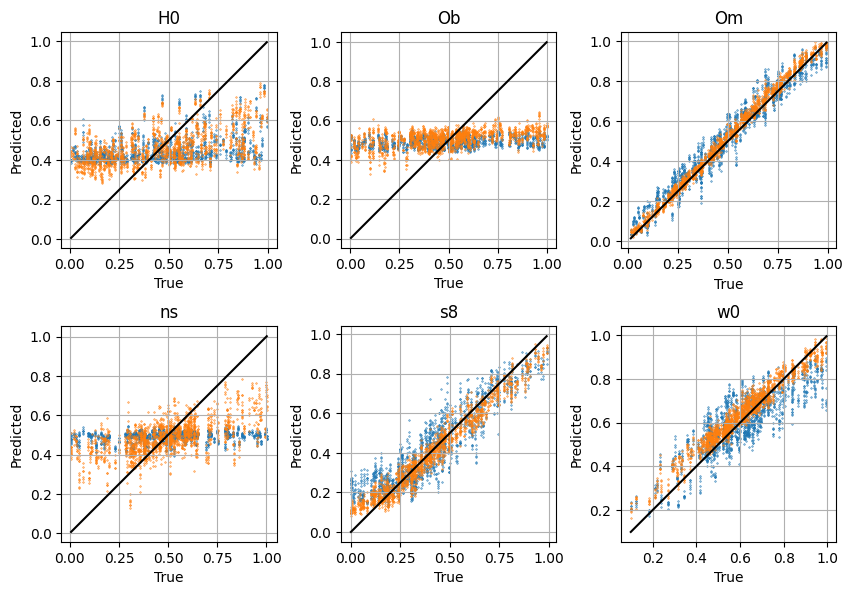

In [3]:
labels = ["H0", "Ob", "Om", "ns", "s8", "w0"]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
# add hspace and vspace
fig.subplots_adjust(wspace=0.3, hspace=0.2)
for i in range(6):
    axs[i//3, i%3].scatter(vit_labels[:, i], vit_preds[:, i], marker="x", alpha=0.5, s=1)
    axs[i//3, i%3].scatter(resnet_labels[:, i], resnet_preds[:, i], marker="x", alpha=0.5, s=1)
    axs[i//3, i%3].plot([np.min(vit_labels[:, i]), np.max(vit_labels[:, i])], \
                        [np.min(vit_labels[:, i]), np.max(vit_labels[:, i])], c="k")
    axs[i//3, i%3].set_xlabel("True")
    axs[i//3, i%3].set_ylabel("Predicted")
    axs[i//3, i%3].set_aspect("equal")
    axs[i//3, i%3].set_title(labels[i])
    axs[i//3, i%3].grid()
plt.show()
plt.close()

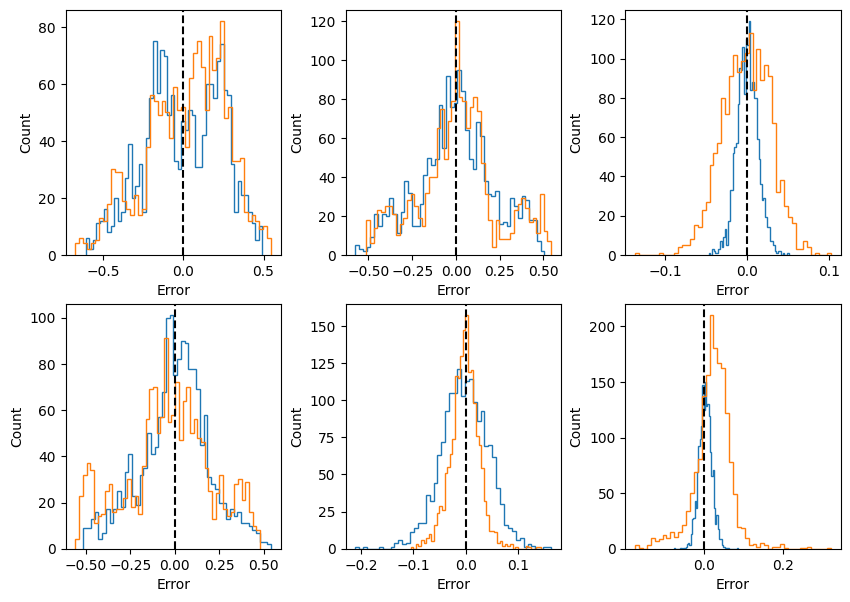

In [5]:
labels = ["H0", "Ob", "Om", "ns", "s8", "w0"]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
# add hspace and vspace
fig.subplots_adjust(wspace=0.3, hspace=0.2)
for i in range(6):
    axs[i//3, i%3].hist(vit_preds[:, i] - vit_labels[:, i], bins=50, label=labels[i], histtype='step')
    axs[i//3, i%3].hist(resnet_preds[:, i] - resnet_labels[:, i], bins=50, label=labels[i], histtype='step')
    axs[i//3, i%3].set_xlabel("Error")
    axs[i//3, i%3].set_ylabel("Count")
    axs[i//3, i%3].axvline(x=0, color='k', linestyle='--')
plt.show()
plt.close()

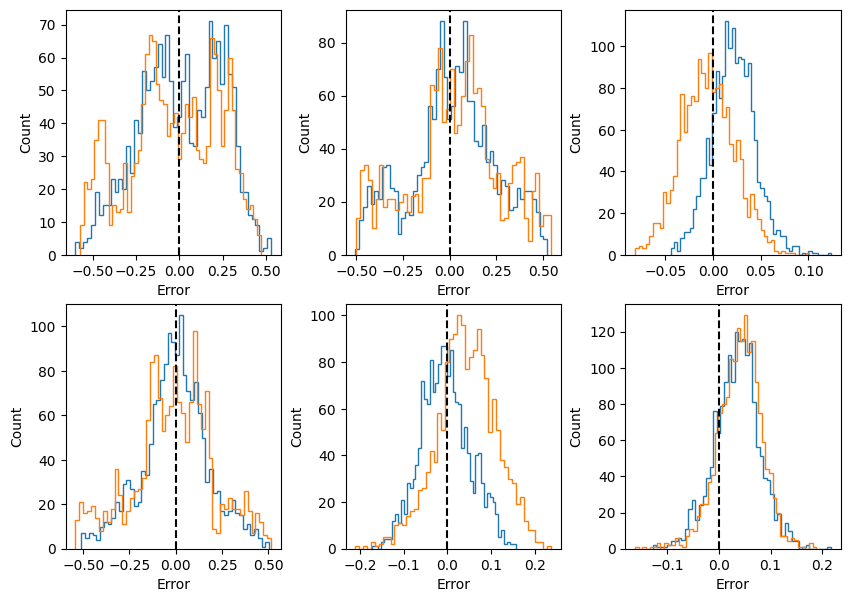

In [21]:
labels = ["H0", "Ob", "Om", "ns", "s8", "w0"]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
# add hspace and vspace
fig.subplots_adjust(wspace=0.3, hspace=0.2)
for i in range(6):
    axs[i//3, i%3].hist(vit_preds[:, i] - vit_labels[:, i], bins=50, label=labels[i], histtype='step')
    axs[i//3, i%3].hist(resnet_preds[:, i] - resnet_labels[:, i], bins=50, label=labels[i], histtype='step')
    axs[i//3, i%3].set_xlabel("Error")
    axs[i//3, i%3].set_ylabel("Count")
    axs[i//3, i%3].axvline(x=0, color='k', linestyle='--')
plt.show()
plt.close()

In [10]:
indices = (2, 4, 5)
vit_preds, resnet_preds, vit_labels, resnet_labels = \
    vit_preds[:, indices], resnet_preds[:, indices], vit_labels[:, indices], resnet_labels[:, indices]

In [11]:
ind = np.random.randint(0, len(vit_labels))
ind = 1590
x_0_vit = vit_preds[ind]
true = vit_labels[ind]

# rn_ind = np.where(np.all(resnet_labels == true, axis=1))[0][0]
rn_ind = ind
x_0_resnet = resnet_preds[rn_ind]
print(ind, rn_ind)
print(x_0_vit, x_0_resnet)
print(true, resnet_labels[rn_ind])

inds = np.delete(np.arange(0, len(vit_labels)), ind)
vit_labels, vit_preds = vit_labels[inds], vit_preds[inds]
inds = np.delete(np.arange(0, len(resnet_labels)), rn_ind)
resnet_labels, resnet_preds = resnet_labels[inds], resnet_preds[inds]

1590 1590
[0.3117415  0.63396989 0.54456719] [0.32599734 0.70621784 0.52761536]
[0.30074784 0.6601868  0.5341454 ] [0.30074784 0.6601868  0.5341454 ]


In [12]:
prior = utils.BoxUniform(low=np.min(vit_labels, axis=0), high=np.max(vit_labels, axis=0))
proposal = prior
inference = SNPE(prior=prior, density_estimator=utils.posterior_nn(model='made',
                                                hidden_features=50,
                                                num_transforms=4))
theta, x = torch.FloatTensor(vit_labels), torch.FloatTensor(vit_preds)
density_estimator = inference.append_simulations(theta, x).train()
posterior_vit = inference.build_posterior(density_estimator)

proposal = prior
inference = SNPE(prior=prior, density_estimator=utils.posterior_nn(model='made',
                                                hidden_features=50,
                                                num_transforms=4))

theta, x = torch.FloatTensor(resnet_labels), torch.FloatTensor(resnet_preds)
density_estimator = inference.append_simulations(theta, x).train()
posterior_resnet = inference.build_posterior(density_estimator)

 Neural network successfully converged after 66 epochs.

In [13]:
posterior_samples_vit = posterior_vit.set_default_x(x_0_vit).sample((10000,), x=x_0_vit)
posterior_samples_resnet = posterior_resnet.set_default_x(x_0_resnet).sample((10000,), x=x_0_resnet)

Drawing 10000 posterior samples: 10244it [00:00, 118810.33it/s]           
Drawing 10000 posterior samples: 10217it [00:00, 197510.24it/s]           


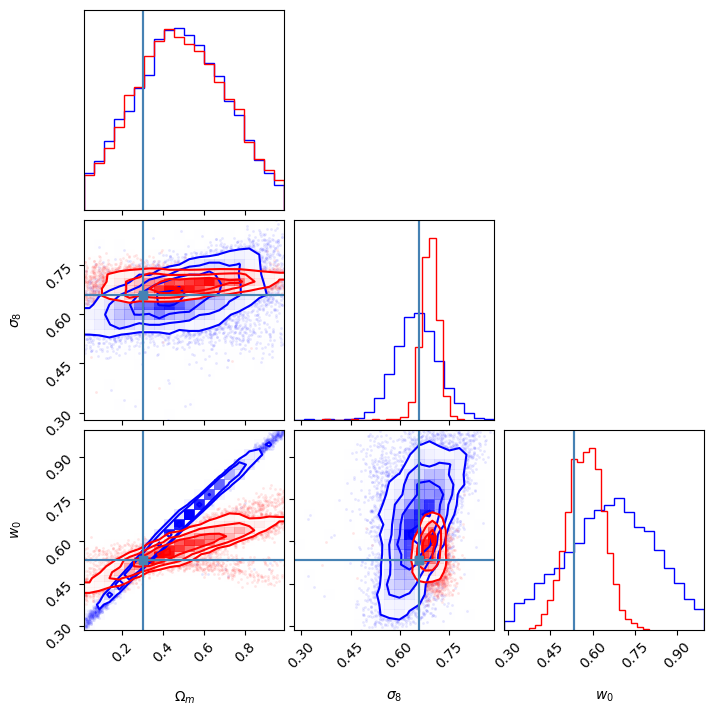

In [14]:
fig = corner.corner(np.array(posterior_samples_vit), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

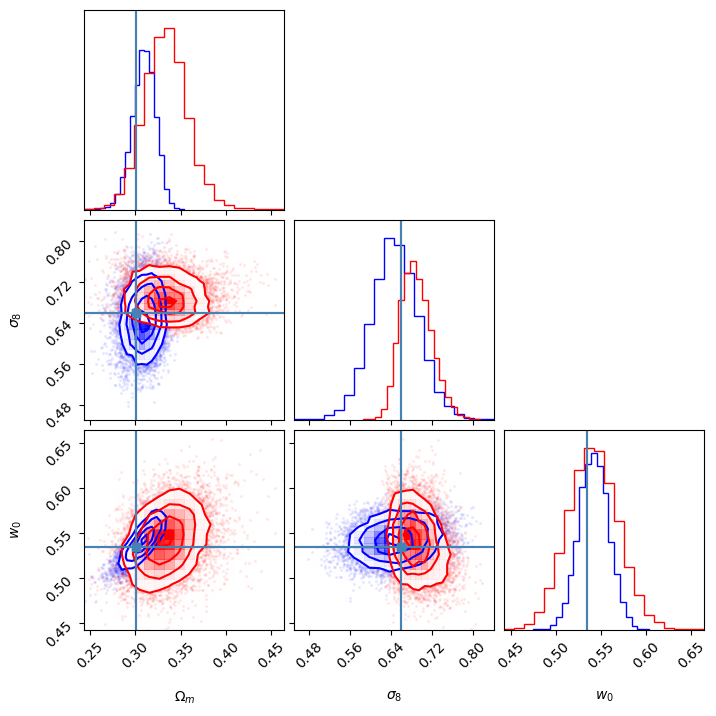

In [8]:
fig = corner.corner(np.array(posterior_samples_vit), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

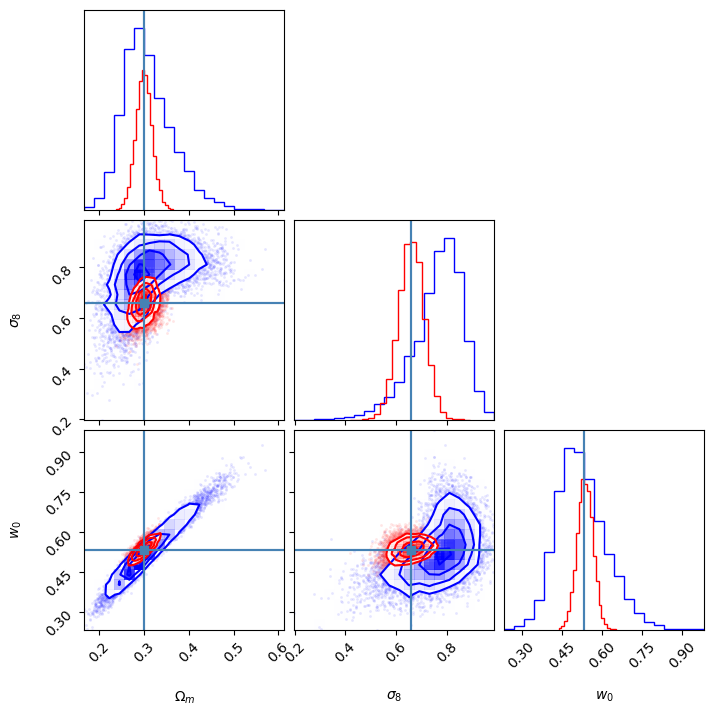

In [15]:
fig = corner.corner(np.array(posterior_samples_vit), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red", title="ViT")

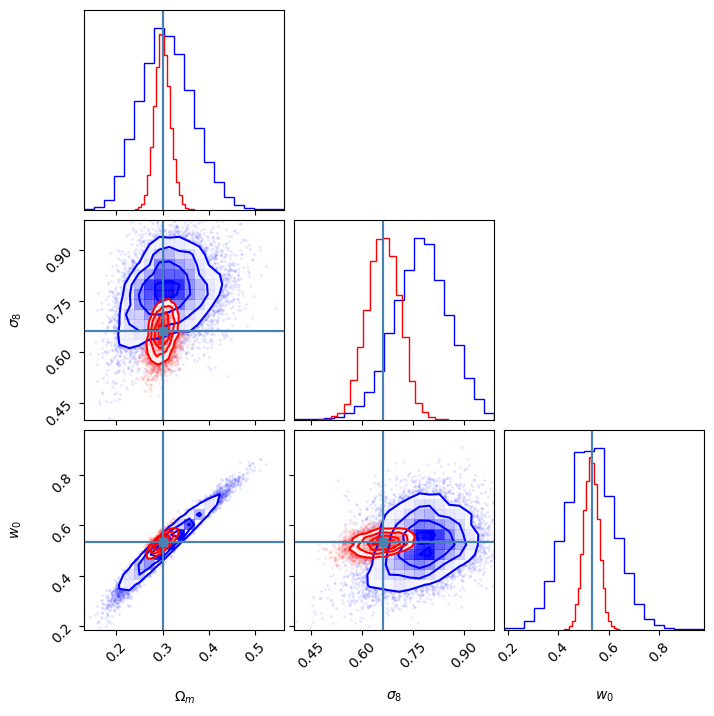

In [7]:
fig = corner.corner(np.array(posterior_samples_vit), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red", title="ViT")

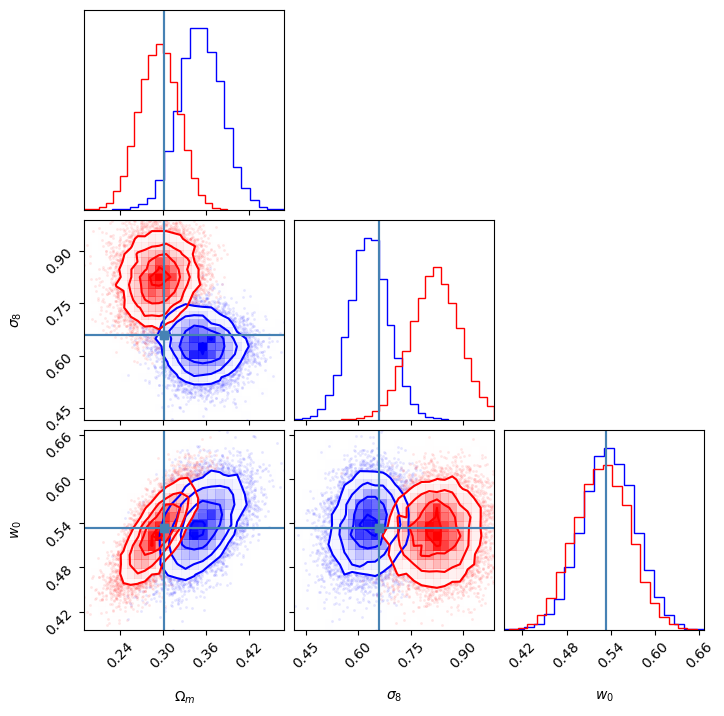

In [10]:
fig = corner.corner(np.array(posterior_samples_vit), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red", title="ViT")

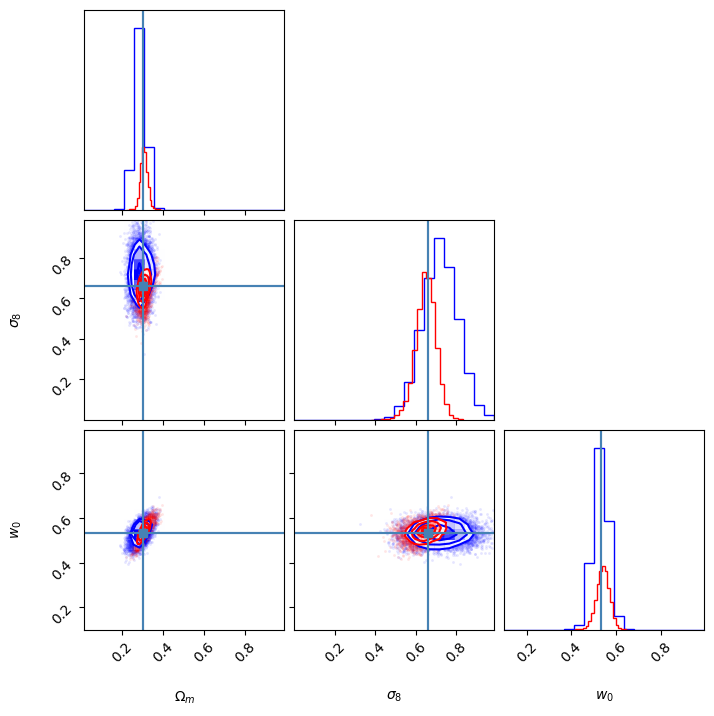

In [14]:
fig = corner.corner(np.array(posterior_samples_resnet), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue", range=np.array([np.min(vit_labels, axis=0), np.max(vit_labels, axis=0)]).T)
fig = corner.corner(np.array(posterior_samples_vit), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red", title="ViT")

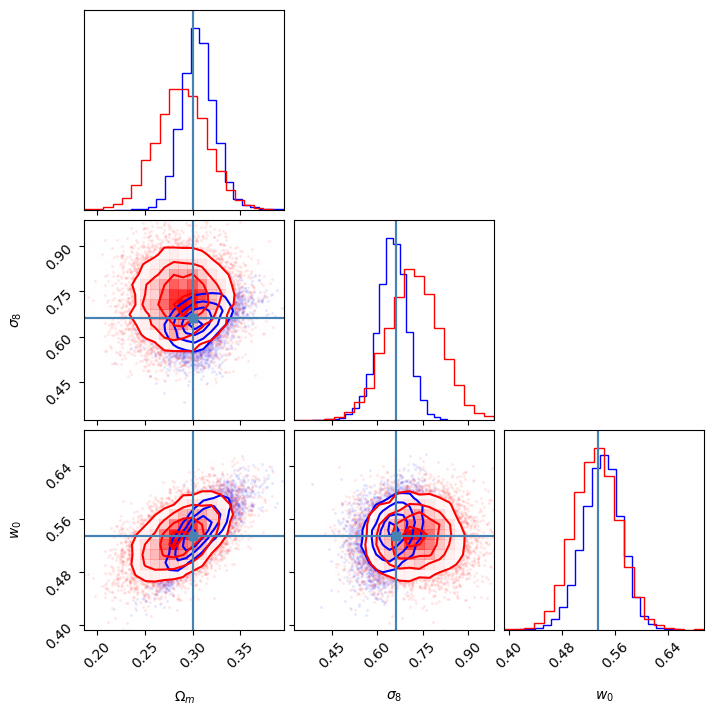

In [11]:
fig = corner.corner(np.array(posterior_samples_vit), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red", title="ViT")

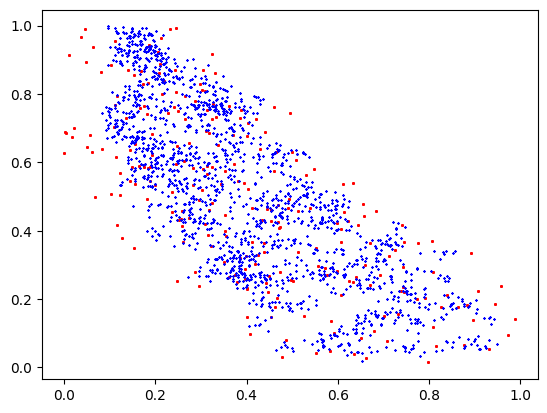

In [21]:
plt.figure()
plt.scatter(resnet_labels[:, 1], resnet_labels[:, 0], c='r', s=1, marker='x')
plt.scatter(resnet_preds[:, 1], resnet_preds[:, 0], c='b', s=1, marker='x')
plt.show()
plt.close()

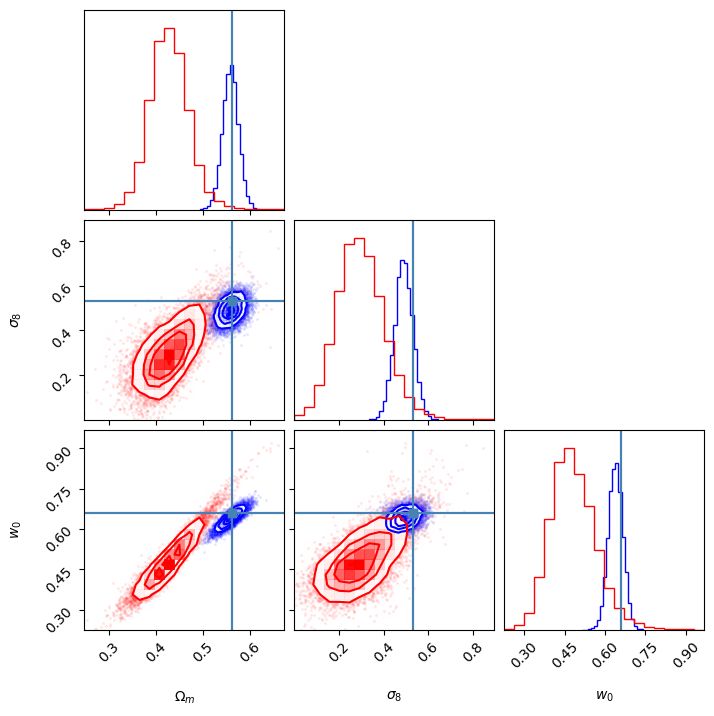

In [93]:
fig = corner.corner(np.array(posterior_samples_vit), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

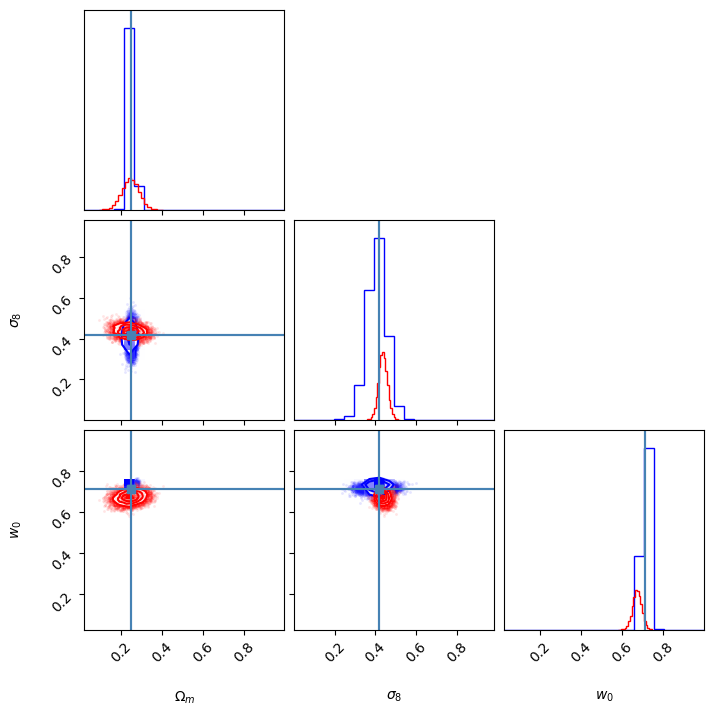

In [18]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue", range=np.array([np.min(vit_labels, axis=0), np.max(vit_labels, axis=0)]).T)
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

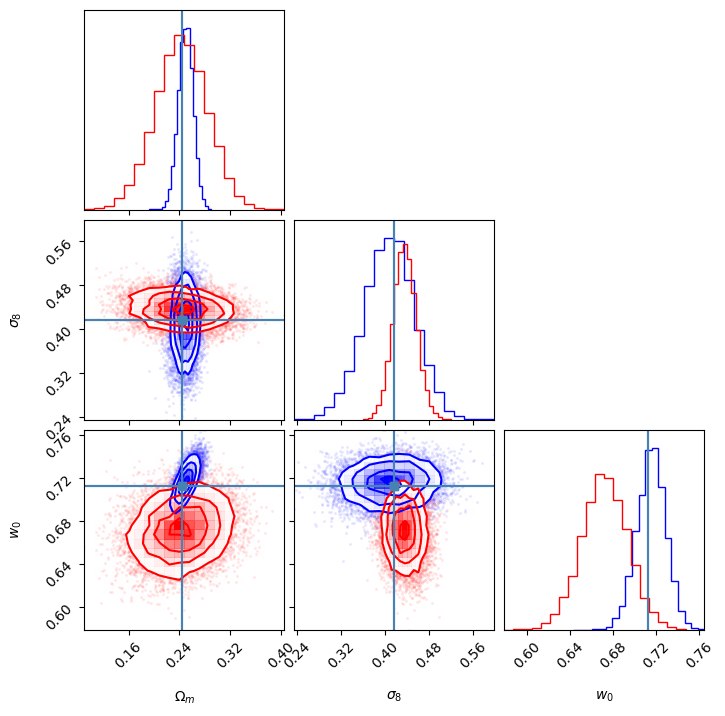

In [19]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

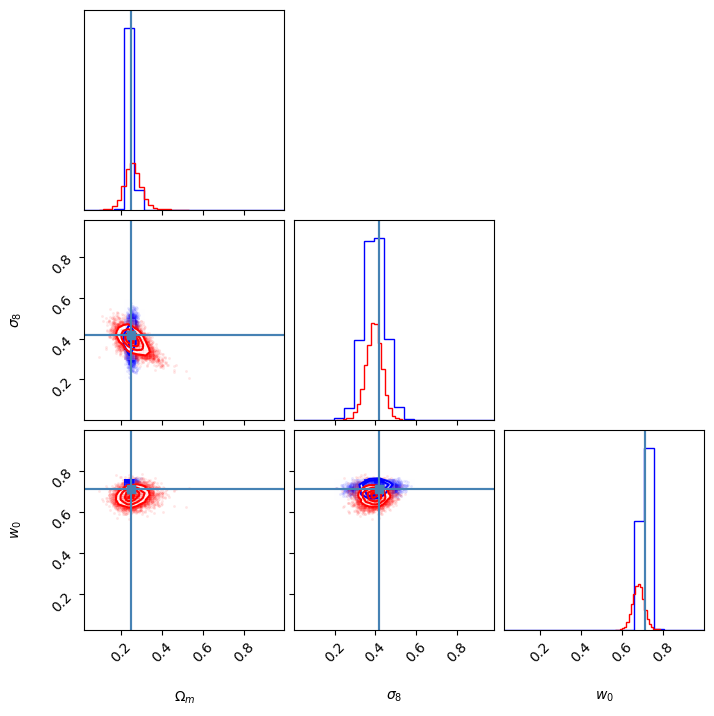

In [ ]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue", range=np.array([np.min(vit_labels, axis=0), np.max(vit_labels, axis=0)]).T)
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

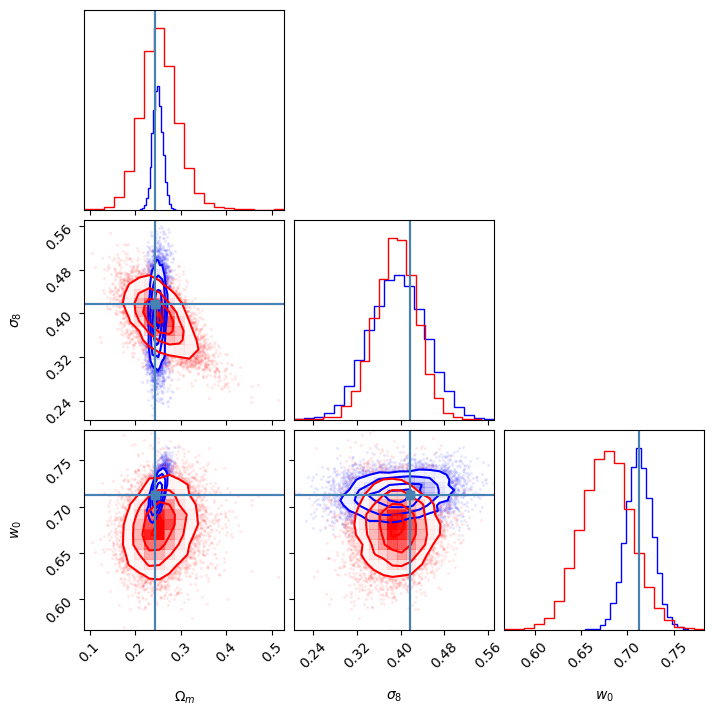

In [ ]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")